In [3]:
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta

from utils import train, eval_loss, Flow1d, generate_mixture_of_2_gaussians, NumpuDataset
import torch.utils.data as data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import torch

/home/quan/flow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
n_train, n_test = 2000, 1000

train_data = generate_mixture_of_2_gaussians(n_train)
test_data = generate_mixture_of_2_gaussians(n_test)

train_loader = data.DataLoader(NumpuDataset(train_data), batch_size=128, shuffle=True)
test_loader = data.DataLoader(NumpuDataset(test_data), batch_size=128, shuffle=True)

Visualize training and testing data

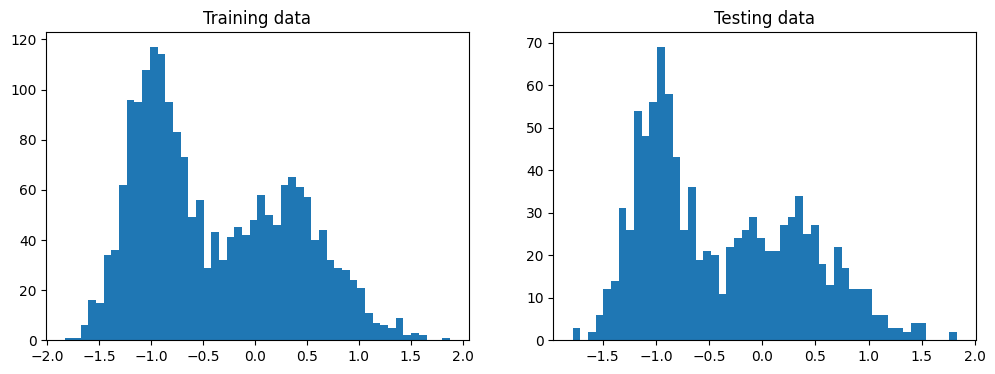

In [5]:
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].hist(train_loader.dataset.array, bins=50)
_ = axes[1].hist(test_loader.dataset.array, bins=50)
_ = axes[0].set_title('Training data')
_ = axes[1].set_title('Testing data')

Train the flow model

In [6]:
target_distribution = Uniform(0.0,1.0)

def train_and_eval(epochs, lr, train_loader, test_loader, target_distribution):
    flow = Flow1d(n_components=5)
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train(flow, train_loader, optimizer, target_distribution)
        train_losses.append(eval_loss(flow, train_loader, target_distribution))
        test_losses.append(eval_loss(flow, test_loader, target_distribution))
    return flow, train_losses, test_losses
    
flow, train_losses, test_losses = train_and_eval(50, 5e-3, train_loader, test_loader, target_distribution)

View the losses

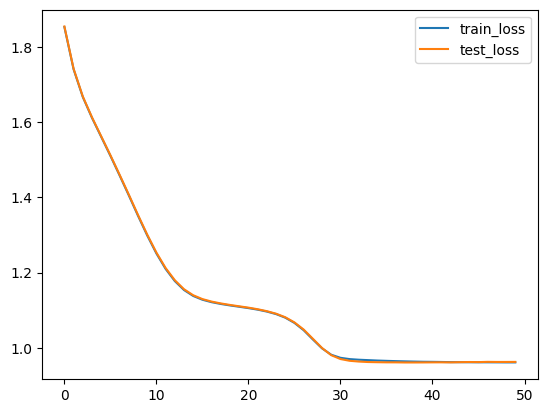

In [7]:
_ = plt.plot(train_losses, label='train_loss')
_ = plt.plot(test_losses, label='test_loss')
plt.legend()

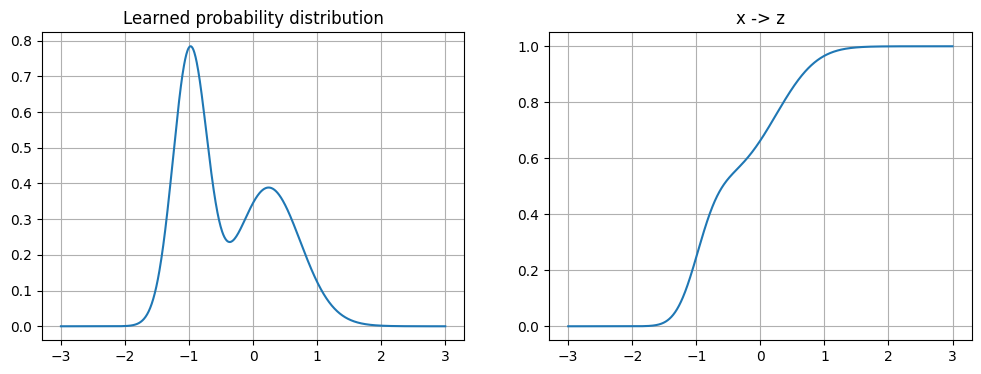

In [8]:
x = np.linspace(-3,3,1000)
with torch.no_grad():
    z, log_dz_by_dx = flow(torch.FloatTensor(x))
    px = (target_distribution.log_prob(z) + log_dz_by_dx).exp()
    
_, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].grid(), axes[1].grid()
_ = axes[0].plot(x,px)
_ = axes[0].set_title('Learned probability distribution')

_ = axes[1].plot(x,z)
_ = axes[1].set_title('x -> z')


Empirical distribution of z

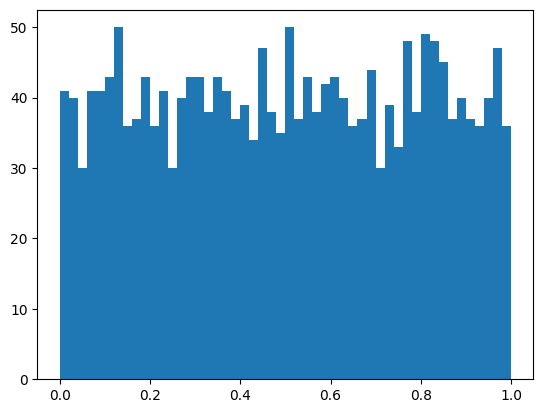

In [9]:
with torch.no_grad():
    z, dz_by_dx = flow(torch.FloatTensor(train_loader.dataset.array))
    px = (target_distribution.log_prob(z) + dz_by_dx.log()).exp().cpu().numpy()
    
_ = plt.hist(z, bins=50)